In [72]:
import celerite
import numpy as np
from celerite import terms
from lightkurve import KeplerLightCurveFile
from scipy.optimize import minimize
import matplotlib.pyplot as plt

str = KeplerLightCurveFile.from_archive(206208968)
strPDC = str.PDCSAP_FLUX.remove_outliers()

Found 1 File(s)
INFO: Found cached file ./mastDownload/K2/ktwo206208968-c03_lc/ktwo206208968-c03_llc.fits with expected size 368640. [astroquery.query]


/anaconda/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/anaconda/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


In [73]:
y = strPDC.flux[:200] # set and clean data
x = strPDC.time[:200]
y = (y/np.median(y)) - 1
x = x[np.isfinite(y)]
y = y[np.isfinite(y)]

In [74]:
Q = 1.0/np.sqrt(2.0)
w0 = 5.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15,15), log_Q=(-15,15), log_omega0=(-15,15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)
kernel.freeze_parameter("log_Q")

Q = 1.0
w0 = 5.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0 = np.log(S0), log_Q = np.log(Q), log_omega0 = np.log(w0), bounds = bounds)

In [75]:
gp = celerite.GP(kernel, mean = np.mean(y))
gp.compute(x,y)
print("initial log likelihood: {0}".format(gp.log_likelihood(y)))

initial log likelihood: 866.8091577046501


In [76]:
print(gp.get_parameter_names())

('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')


In [77]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method = "L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -874.6853187271325
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.43245416e-03,  9.77706804e-04, -6.82121026e-05, -4.54747351e-05,
       -6.82121026e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 210
      nit: 29
   status: 0
  success: True
        x: array([-13.85234672,   2.37179189,  -3.01675864,  -6.98026665,
        -3.83765148])


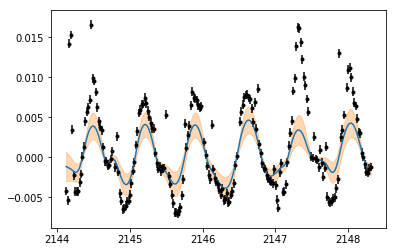

In [80]:
color = "#ff7f0e"
pred_mean, pred_var = gp.predict(y,x,return_var=True)
pred_std = np.sqrt(pred_var)
plt.plot(x, pred_mean)
plt.errorbar(x, y, yerr=np.var(y)**0.5/10, fmt='k.')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")